In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

pd.options.display.max_columns = 1000      # set column display
pd.options.display.max_rows = 1000         # set row display
pd.options.mode.chained_assignment = None  # default='warn'

yr_20 = gpd.read_file('../data/shapefiles/joined/merged20_final.geojson')
yr_19 = gpd.read_file('../data/shapefiles/joined/merged19_final.geojson')

## Yearly Joined Data

In [2]:
print(f"2019: {yr_19.shape[0]} records, {yr_19.shape[1]} features")
print(f"2020: {yr_20.shape[0]} records, {yr_20.shape[1]} features")
print()
print(f"Missing Features 2020: {set(yr_19.columns) - set(yr_20.columns)}")

2019: 287760 records, 29 features
2020: 290158 records, 26 features

Missing Features 2020: {'fhv_outflow_counts', 'uid', 'fhv_inflow_counts'}


## Identifying Nightlife Clusters

In [3]:
venues = gpd.read_file('../data/shapefiles/nyc/venues_hexbinned.geojson')

boros = gpd.read_file('../data/shapefiles/nyc/boro_bounds.geojson')
boros = boros.to_crs(venues.crs)

subways = gpd.read_file('../data/shapefiles/subway/routes/routes_nyc_subway_may2019.shp').to_crs(venues.crs)

In [4]:
# calculate pct. share of businesses that are venues
venues['venue_pct'] = (venues['venue_count'] / venues['business_count']) * 100

# calculate z score for citywide data
venues['count_z'] = np.abs(stats.zscore(venues['venue_count']))
venues['pct_z'] = (venues['venue_pct'] - venues['venue_pct'].mean())/\
                   venues['venue_pct'].std()

# add borough information to venues data
venues = gpd.sjoin(venues,
                   boros[['boro_code', 'boro_name', 'geometry']],
                   how='left'
                  )\
            .drop(['index_right'],
                  axis=1
                 )

# eliminate duplicates along boro borders
venues.drop_duplicates(subset='hex_id_8',
                       keep='first',
                       inplace=True
                      )

venues.head(3)

,hex_id_8,venue_count,business_count,geometry,venue_pct,count_z,pct_z,boro_code,boro_name
0,882a100d65fffff,144.0,6412,"POLYGON ((301714.781 65863.222, 301880.715 663...",2.245789,12.351170,0.904274,1,Manhattan
1,882a1072cbfffff,136.0,2761,"POLYGON ((300594.554 61028.530, 301133.174 611...",4.925752,11.648765,2.431049,1,Manhattan
2,882a100d2dfffff,110.0,16567,"POLYGON ((301010.106 65250.815, 300471.361 651...",0.663971,9.365951,0.003113,1,Manhattan


The mean value per hexbin is 3.33 venues.
The standard deviation (1Z) is 11.39 venues.

Nightlife venues make up 0.66% of the businesses in the mean hexbin.
The standard deviation (1Z) is 1.76%.



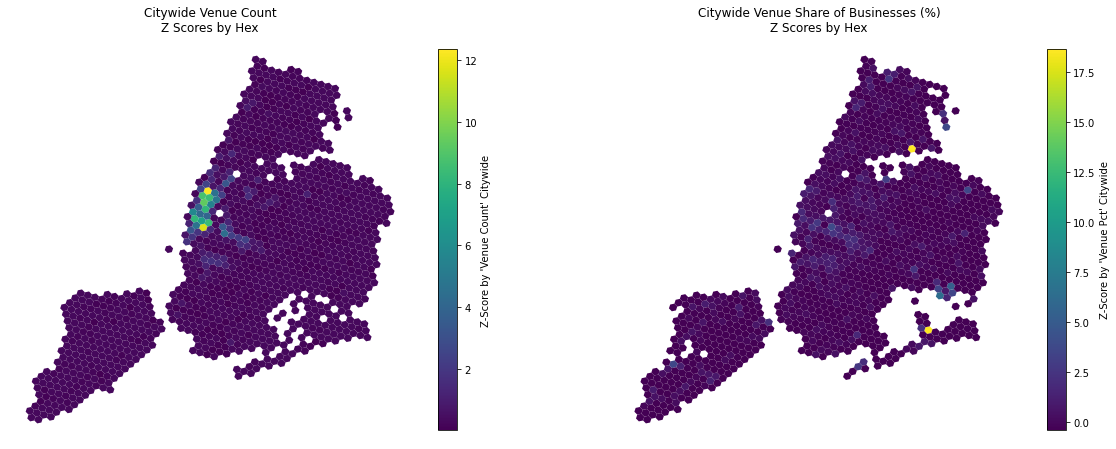

In [71]:
fig, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].axis('off')
ax[0].set_title('Citywide Venue Count\nZ Scores by Hex')

ax[1].axis('off')
ax[1].set_title('Citywide Venue Share of Businesses (%)\nZ Scores by Hex')

print(f"The mean value per hexbin is {round(venues.venue_count.mean(),2)} venues.\n"+\
      f"The standard deviation (1Z) is {round(venues.venue_count.std(),2)} venues.\n")

print(f"Nightlife venues make up {round(venues.venue_pct.mean(),2)}% of the businesses in the mean hexbin.\n"+\
      f"The standard deviation (1Z) is {round(venues.venue_pct.std(),2)}%.\n")

venues.plot(ax          = ax[0],
            figsize     = (15,15),
            column      = 'count_z',
            legend      = True,
            legend_kwds = {'label': "Z-Score by 'Venue Count' Citywide",
                           'orientation': 'vertical',
                           'shrink': 0.35});

venues.plot(ax          = ax[1],
            figsize     = (15,15),
            column      = 'pct_z',
            legend      = True,
            legend_kwds = {'label': "Z-Score by 'Venue Pct' Citywide",
                           'orientation': 'vertical',
                           'shrink': 0.35});

#### Fig. 1: Maps of Citywide Nightlife Cluster Outliers (colored by Z-score of venue count and venue pct.)

The mean value per hexbin is 3.33 venues.
The standard deviation (1Z) is 11.39 venues.

Nightlife venues make up 0.66% of the businesses in the mean hexbin.
The standard deviation (1Z) is 1.76%.



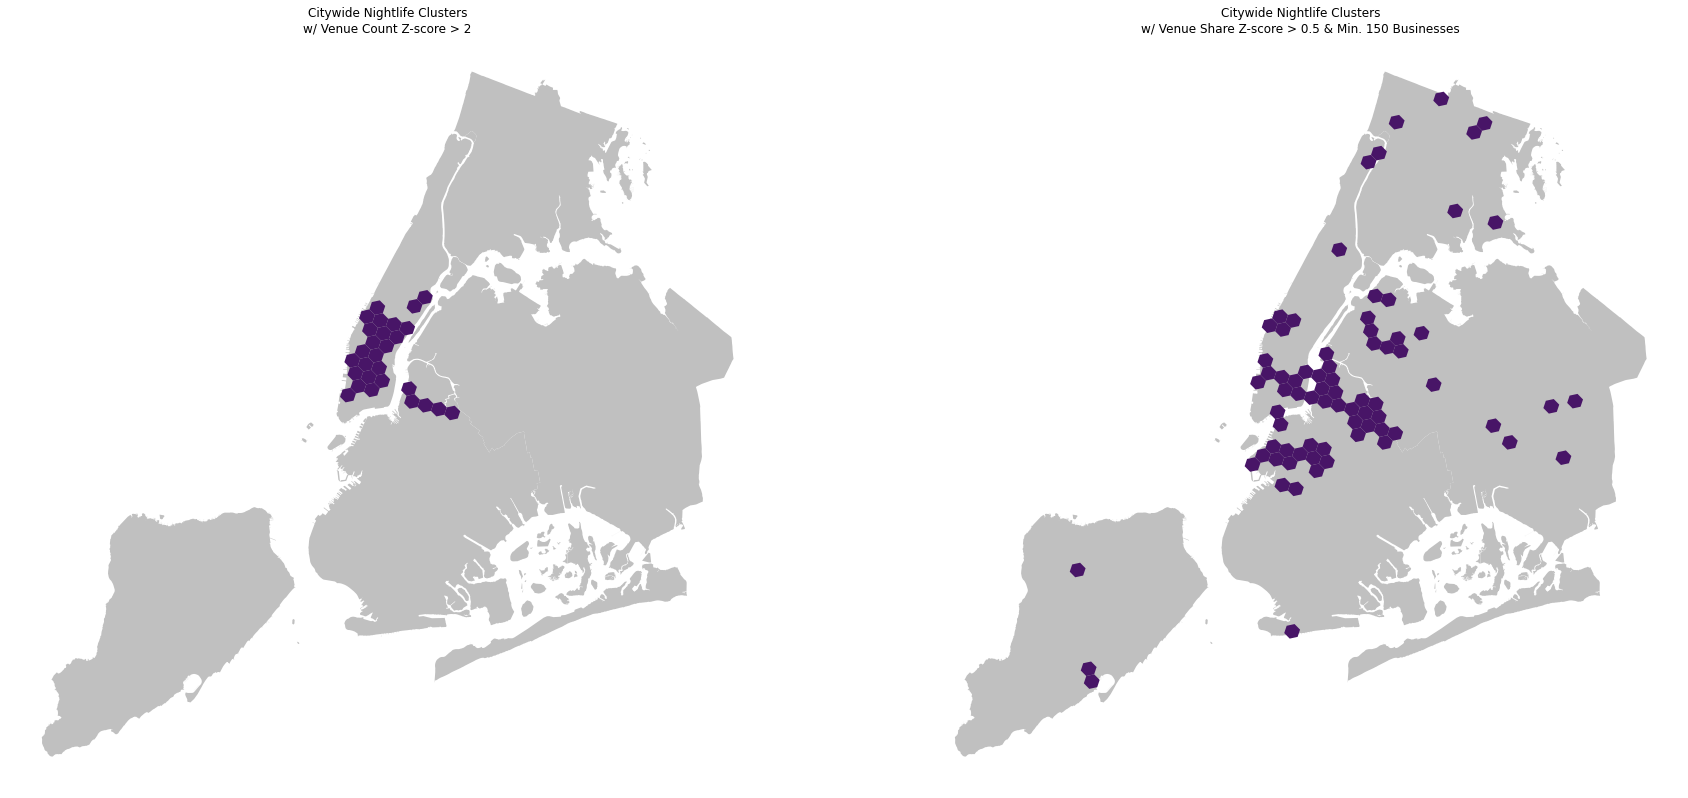

In [133]:
print(f"The mean value per hexbin is {round(venues.venue_count.mean(),2)} venues.\n"+\
      f"The standard deviation (1Z) is {round(venues.venue_count.std(),2)} venues.\n")

print(f"Nightlife venues make up {round(venues.venue_pct.mean(),2)}% of the businesses in the mean hexbin.\n"+\
      f"The standard deviation (1Z) is {round(venues.venue_pct.std(),2)}%.\n")

z_threshold = .5
biz_threshold = 150

fig, ax = plt.subplots(1,2,figsize=(30,40))

ax[0].axis('off')
ax[0].set_title(f"Citywide Nightlife Clusters\nw/ Venue Count Z-score > 2");

ax[1].axis('off')
ax[1].set_title(f"Citywide Nightlife Clusters\nw/ Venue Share Z-score > " +
                f"{z_threshold} & Min. {biz_threshold} Businesses");

# Basemap for each ax in the fig.
boros.plot(ax=ax[0], color='silver', zorder=1, figsize=(15,15))
boros.plot(ax=ax[1], color='silver', zorder=1, figsize=(15,15))

# # Add subway lines (add colors?)
# subways.plot(ax=ax, color='red', alpha=0.2, zorder=3)

# Venue Count Z Score
venues[venues['count_z'] > 2].plot(ax     = ax[0],
                                   color  = '#481567FF',
                                   zorder = 2)

# Venue Pct. Z Score
venues[(venues['pct_z'] > z_threshold) &\
       (venues['business_count'] > biz_threshold)].plot(ax = ax[1],
                                                        color = '#481567FF',
                                                        zorder=2);

#### Fig. 2: Maps of Citywide Nightlife Cluster Outliers (filtered by Z-Score of Venue Count and Venue%)

Hexes in the left map contain at least 

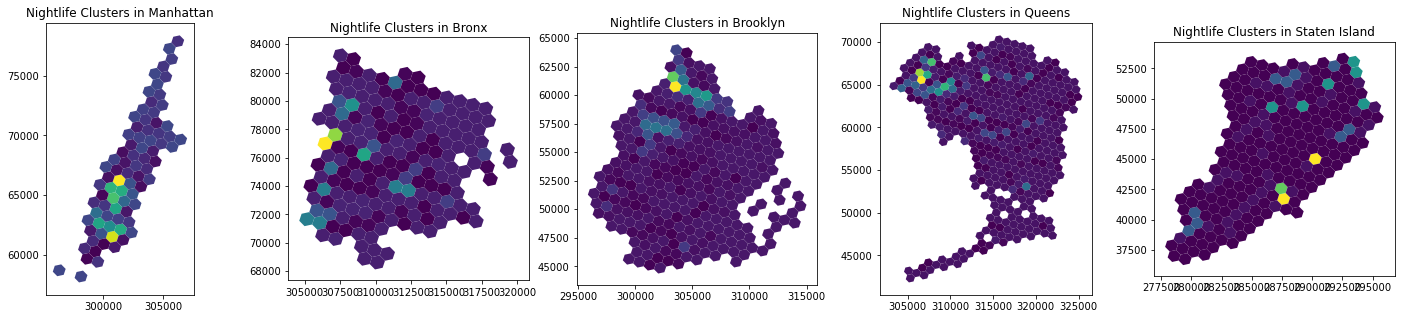

In [9]:
fig, ax = plt.subplots(1,5, figsize = (25,5))

for i in range(1,6):
    # access specific axis and filter data by boro
    sel_ax = ax[i-1]
    boro_venues = venues[venues['boro_code'].astype(int) == int(i)]
    
    # calculate z score
    boro_venues['count_z'] = np.abs(stats.zscore(boro_venues['venue_count']))

    # set up plot
    boro_name = list(set(boro_venues['boro_name']))[0]
    boro_venues.plot(ax    =sel_ax,
                     column='count_z'
                    )
    sel_ax.title.set_text(f"Nightlife Clusters in {boro_name}")

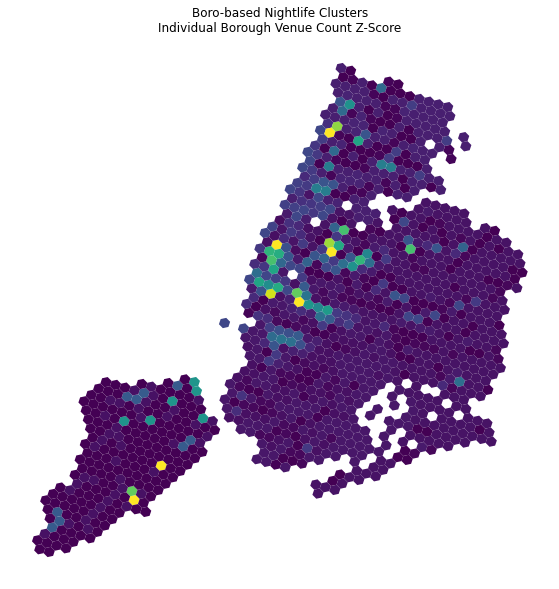

In [90]:
fig, ax = plt.subplots(1,1, figsize = (10,10))
ax.set_title(f"Boro-based Nightlife Clusters\nIndividual Borough Venue Count Z-Score")
ax.axis('off')

for i in range(1,6):
    # filter data by boro
    boro_venues = venues[venues['boro_code'].astype(int) == int(i)]
    
    # calculate z score
    boro_venues['z'] = np.abs(stats.zscore(boro_venues['venue_count']))

    # set up plot and add boro data
    boro_name = list(set(boro_venues['boro_name']))[0]
    boro_venues.plot(ax=ax,
                     column='z')

In [11]:
## EXPORTS:

# venues.to_file("../data/shapefiles/venues/venue_zscores.geojson",
#                driver='GeoJSON')

# venues[(venues['pct_z'] > .5) & (venues['business_count'] > 150)].to_file("../data/shapefiles/venues/nightlife_cluster_hexes.geojson",
#                driver='GeoJSON')